In [1]:
import pandas as pd
import numpy as np
import os
import nltools as nlt
import nilearn as nil
import nibabel as nib
import warnings
import glob
import random
import pickle

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
pd.set_option('display.max_rows', 99)

In [3]:
#load behavioral data

import dev_wtp_io_utils
behavioral_data_path = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/Tasks/WTP/output/'
[run_list, run_event_df_list, run_event_stage_df_list] = dev_wtp_io_utils.get_comprehensive_run_data_from_mat_dir(behavioral_data_path)



subject 040, subject 039, subject 168, subject 063, subject 129, subject 067, subject 150, subject 159, 
SUBJ 159, 2, run14
no data for this run.
subject 004, subject 091, subject 180, subject 008, subject 095, subject 099, subject 032, 
SUBJ 032, 2, run2
no data for this run.
subject 036, subject 171, subject 100, 
SUBJ 100, 3, run2
no data for this run.
subject 109, subject 041, subject 060, subject 059, subject 130, subject 064, subject 068, subject 001, subject 087, subject 192, subject 005, subject 121, subject 999, 
SUBJ 999, 2, run1
no data for this run.


SUBJ 999, 2, run2
Data for this run is not in the expected format or is missing. Skipping this run.
time: 29-Oct-2020 17:09:09

StartTime: 3035.874545661

Jitter: array of length 16

TrialStart: array of length 2

ISI: array of length 2

FoodOn: array of length 2

BidOn: array of length 2

FoodOnset: array of length 2

BidOnset: array of length 2

FoodDuration: array of length 2

BidDuration: array of length 2

FoodPic: array 

In [4]:
#load design data
betas = pd.read_csv("../data/DEV QC and Exclusions - betas_machine_readable.csv")
wtp_betas = betas[betas.task=='WTP betas']
#get the betas just for the four runs
wtp_betas_runfiles = wtp_betas[[bt in ['run1','run2','run3','run4'] for bt in wtp_betas.type]].copy()
#number them
wtp_betas_runfiles['event_id'] = wtp_betas_runfiles.groupby('type').cumcount()+1

Now combine the design and behavioral data:

In [5]:
wtpw1_behavdesign = wtp_betas_runfiles.merge(run_event_df_list, how='left',
                         left_on=['type','event_id'],
                        right_on=['run','event_id'])

wtpw1_behavdesign = wtpw1_behavdesign[(wtpw1_behavdesign.wave==1)]

wtpw1_behavdesign.sample(5)


,beta,type,task,event_id,isi_pre,onset,duration,food_pic,food_num,cond,health_cond,liking_cond,liking_rating,response,isi_post,end,run,wave,subject
16919,beta_0032.nii,run2,WTP betas,11,0.665879,116.691363,6.532913,HotTamales.bmp,11,unhealthy_disliked,unhealthy,disliked,1,5,0.925946,123.224276,run2,1,DEV113
16072,beta_0031.nii,run2,WTP betas,10,0.800571,106.364669,6.527269,ClifBar2.bmp,10,healthy_disliked,healthy,disliked,1,5,0.665879,112.891938,run2,1,DEV040
21057,beta_0044.nii,run3,WTP betas,2,3.000000,18.657909,6.528072,ClifBar2.bmp,2,healthy_liked,healthy,liked,4,8,1.780283,25.185981,run3,1,DEV047
2373,beta_0004.nii,run1,WTP betas,4,0.095117,39.726924,6.530774,HotTamales.bmp,4,unhealthy_disliked,unhealthy,disliked,1,5,2.680966,46.257698,run1,1,DEV182
4700,beta_0008.nii,run1,WTP betas,8,2.083661,84.906108,6.532283,chilifritos.bmp,8,unhealthy_disliked,unhealthy,disliked,1,5,1.584060,91.438390,run1,1,DEV093


In [6]:
#iterate through subject directories.

subject_dirs_all = glob.glob('/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/WTP/wave1/betaseries/sub-DEV*')
subject_dirs_all.sort()

In [7]:
#pick 10 at random for testing.


In [76]:
random.seed(a=1622149277.6487303)
subject_dirs = random.sample(subject_dirs_all,k=10)
subject_dirs.sort()

In [77]:
import re
sub_labels = [(re.search("DEV(\\d\\d\\d)",sid)[0]) for sid in subject_dirs]
sub_ids = [(int)(re.search("DEV(\\d\\d\\d)",sid)[1]) for sid in subject_dirs]

In [78]:
#get the neural data for each subject
sub_ids

[1, 46, 49, 51, 53, 58, 60, 71, 87, 89]

In [79]:
wtpw1_behavdesign_set = wtpw1_behavdesign[[s in sub_labels for s in wtpw1_behavdesign.subject]]

In [80]:
def get_Brain_Data_for_sub(sub_label,behavdesign):
    subj_behav_design = behavdesign[[s in sub_label for s in behavdesign.subject]]
    del(behavdesign)
    
    subject_dir = (
        '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/WTP/wave1/betaseries/' +
        'sub-' + sub_label + '/'
    )
        
    #set path for the betas

    beta_path_sub049 = os.listdir(subject_dir)

    #iterate through the subjects
    # TO DO
    #iterate through and check all the betas exist
    for betafile in subj_behav_design.beta:
        betafilepath = subject_dir + betafile

        #check if file exists
        if os.path.exists(betafilepath):
            print('.',end='')
        else:
            raise Exception("beta " + betafile + ' does not exist')

    print("...verified that all expected betas exist! Processing...",flush=True,end='')



    #import them, but catch a very specific warning and don't show it because it gets annoying
    #https://docs.python.org/3/library/warnings.html
    with warnings.catch_warnings(record=True) as w:
        subj_data = nlt.Brain_Data([subject_dir + b for b in subj_behav_design.beta],
                                  X=subj_behav_design)
    na_inf_warn_count=0
    for wi in w:
        if wi.message.args[0]!='NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.':
            warnings.warn(wi.message,type(wi))
        else:
            na_inf_warn_count+=1

    if na_inf_warn_count>0:
        print("caught "+ str(na_inf_warn_count) + " instances of the warning:\n" + 
             'NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.')
        
    print('...imported data.')
    return(subj_data)



In [81]:
bd_dict={}
for sl in sub_labels:
    print(sl)
    bd = get_Brain_Data_for_sub(sl,wtpw1_behavdesign)
    bd_dict[sl]=bd

DEV001
...................................................................verified that all expected betas exist! Processing...caught 64 instances of the warning:
NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
...imported data.
DEV046
...................................................................verified that all expected betas exist! Processing...caught 64 instances of the warning:
NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
...imported data.
DEV049
...................................................................verified that all expected betas exist! Processing...caught 64 instances of the warning:
NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
...imported data.
DEV051
...........................

In [90]:
with open('../data/Brain_Data_10subs.pkl', 'wb') as pkl_file:
    pickle.dump(Brain_Data_allsubs,pkl_file)

In [82]:
Brain_Data_allsubs = list(bd_dict.values())[0]
for i in range(1,len(bd_dict.values())):
    print(i)
    val_to_append = list(bd_dict.values())[i]
    Brain_Data_allsubs= Brain_Data_allsubs.append(val_to_append)

1
2
3
4
5
6
7
8
9


now what do we do next?

Let's do a cross-validation across subjects. This is a bit harder! But we'll get an idea.

In [83]:
Brain_Data_allsubs.X.columns

Index(['beta', 'type', 'task', 'event_id', 'isi_pre', 'onset', 'duration',
       'food_pic', 'food_num', 'cond', 'health_cond', 'liking_cond',
       'liking_rating', 'response', 'isi_post', 'end', 'run', 'wave',
       'subject'],
      dtype='object')

In [84]:
Brain_Data_allsubs.Y = Brain_Data_allsubs.X.liking_rating

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.19072e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.72333e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.46114e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.3766e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/home/bsmith16/.conda/envs/neuralsign

overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 1.29
overall CV Correlation: 0.29


{'Y': array([3, 3, 4, 1, 2, 1, 2, 1, 4, 2, 1, 1, 2, 1, 3, 2, 3, 4, 4, 1, 3, 1,
        3, 1, 4, 1, 1, 1, 2, 1, 4, 3, 3, 3, 4, 1, 2, 1, 3, 1, 3, 1, 1, 1,
        1, 1, 3, 3, 3, 4, 3, 1, 3, 2, 3, 1, 3, 2, 1, 1, 1, 2, 4, 3, 3, 3,
        2, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 4, 3, 3, 3, 3, 1, 3, 1, 4, 1,
        3, 1, 1, 1, 1, 1, 3, 3, 3, 4, 4, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1,
        3, 2, 3, 3, 4, 1, 3, 1, 4, 1, 3, 1, 1, 1, 1, 1, 3, 3, 4, 4, 4, 1,
        2, 3, 3, 1, 4, 3, 1, 1, 2, 2, 4, 3, 2, 4, 4, 1, 3, 1, 3, 1, 4, 2,
        1, 1, 1, 2, 4, 4, 4, 4, 4, 1, 3, 1, 3, 1, 4, 3, 1, 1, 2, 1, 4, 3,
        3, 4, 4, 2, 3, 2, 3, 2, 4, 3, 1, 1, 2, 2, 4, 3, 4, 4, 4, 1, 4, 1,
        4, 1, 4, 1, 1, 1, 1, 1, 3, 4, 4, 4, 4, 1, 3, 1, 4, 1, 4, 1, 1, 1,
        1, 1, 4, 4, 4, 4, 4, 1, 3, 1, 4, 1, 3, 2, 1, 1, 1, 1, 3, 4, 4, 4,
        4, 1, 4, 1, 4, 1, 3, 1, 1, 1, 1, 1, 4, 4, 4, 3, 3, 1, 4, 1, 4, 1,
        4, 1, 1, 1, 1, 1, 4, 4, 4, 3, 4, 1, 4, 1, 4, 1, 3, 1, 1, 1, 2, 1,
        4, 4, 4, 3, 4, 1, 4, 1, 4

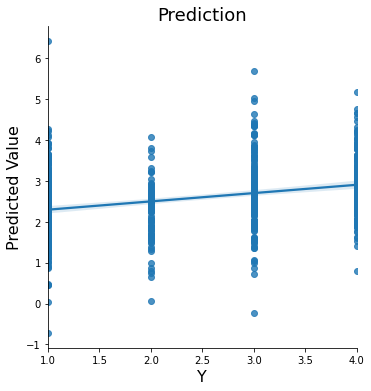

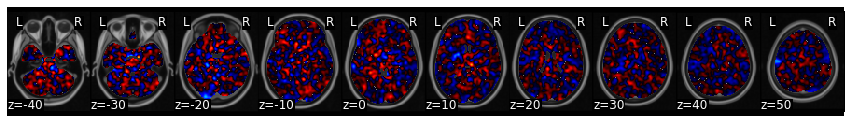

In [85]:
Brain_Data_allsubs.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'subject_id':Brain_Data_allsubs.X.subject})

Now we try within-subject...

In [ ]:
Brain_Data_allsubs.predict(algorithm='ridge',
                           cv_dict = {'type':'kfolds',
                                      'n_folds':5,
                                      'stratified':Brain_Data_allsubs.X.subject})